In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from astropy.table import Table
import astropy.units as u

import arya
import surp
from surp import subgiants
from surp.gce_math import is_high_alpha
from surp._globals import DATA_DIR

In [4]:
np.sum(~subgiants.high_alpha)

10091

In [3]:
filename = surp.DATA_DIR + "allStar-dr17-synspec_rev1.fits"
allStar = Table.read(filename, format="fits", hdu=1, memmap=True)

In [6]:
def bracket(df, ele, ele2="H"):
    """
    Helper function for subgiants()
    creates the abundance ratio [A/B]
    from the  APOGEE dataframe
    """
    if ele2 == "H":
        if ele == "FE":
            return df["FE_H"]
        else:
            return df["%s_FE" % ele] + df["FE_H"]
    else:
        if ele2 == "FE":
            return df["%s_FE" % ele]
        else:
            return df["%s_FE" % ele] - df["%s_FE" % ele2]


In [7]:
df = allStar

# Add useful abundance ratios
df["O_H"] = bracket(df, "O")
df["MG_H"] = bracket(df, "MG")
df["C_O"] = bracket(df, "C", "O")
df["C_MG"] = bracket(df, "C", "MG")
df["C_H"] = bracket(df, "C", "H")

df["C_N"] = bracket(df, "C", "N")
df["N_H"] = bracket(df, "N", "H")
df["N_O"] = bracket(df, "N", "O")
df["N_MG"] = bracket(df, "N", "MG")

df["FE_O"] = -df["O_FE"]
df["FE_MG"] = -df["MG_FE"]

df["C_MG_ERR"] = df["C_FE_ERR"] + df["MG_FE_ERR"]
df["N_MG_ERR"] = df["N_FE_ERR"] + df["MG_FE_ERR"]
df["C_N_ERR"] = df["N_FE_ERR"] + df["C_FE_ERR"]
df["MG_H_ERR"] = df["MG_FE_ERR"] + df["FE_H_ERR"]
df["C_H_ERR"] = df["C_FE_ERR"] + df["FE_H_ERR"]

# add high/low alpha column
df["high_alpha"] = is_high_alpha(df["MG_FE"], df["FE_H"])

allStar = df

del df

See bitmasks in https://www.sdss4.org/dr17/irspec/apogee-bitmasks/#APOGEE_PARAMFLAG

'ancillary young embedded cluster member', 'ancillary emission line star', 'MIR-detected candidate cluster member (ancillary)', 

APOGEE2_Target3: 'Selected as part of the EB program', 'Selected as part of the young cluster study (IN-SYNC)', 'Ancillary W3/4/5 star forming complex'

              

Finally, I restrict to the given Log(g)-Teff domain:
log(g) ≥ 3.5
log(g) ≤ 0.004 ∗ (𝑇eff ) − 15.7
log(g) ≤ 0.00070588 ∗ (𝑇eff ) + 0.358836
log(g) ≤ −0.0015 ∗ (𝑇eff ) + 12.05
log(g) ≥ 0.0012 ∗ (𝑇eff ) − 2.8

In [5]:
apogee_aspcapflag = 0

#apogee_aspcapflag ^= 1<<23 # STAR_BAD (TEFF, LOGG, CHI2, COLORTE, ROTATION, SN, GRIDEDGE_BAD)
# apogee_aspcapflag ^= 1<<31 # NO_ASPCAP_RESULT


# none of these actually change the sample
# apogee_aspcapflag ^= 1<<32 # MISSING_APSTAR
# apogee_aspcapflag ^= 1<<33 # NO_GRID
# apogee_aspcapflag ^= 1<<34 # BAD_FRAC_LOWSNR
# apogee_aspcapflag ^= 1<<35 # BAD_FRAC_BADPIX
# apogee_aspcapflag ^= 1<<36 # FERRE_FAIL
# apogee_aspcapflag ^= 1<<40 # PROBLEM_TARGET
# apogee_aspcapflag ^= 1<<41 # MULTIPLE_SUSPECT


In [9]:
# starflag is a bitwise and for each visit

apogee_starflag = 0

# these don't help
# apogee_starflag ^= 1<<18 # bad_rv_companion
# apogee_starflag ^= 1<<22 # RV_FAIL

In [10]:
apogee_target2 = 0

apogee_target2 ^= 1<<17 # APOGEE_MIRCLUSTER_STAR
apogee_target2 ^= 1<<15 # APOGEE_EMISSION_STAR  emission line stars
apogee_target2 ^= 1<<13 # APOGEE_EMBEDDEDCLUSTER_STAR embedded cluster

In [11]:
apogee2_target3 = 0

apogee2_target3 ^= 1<<1 # APOGEE2_EB eclipsing binary program
apogee2_target3 ^= 1<<5 # APOGEE2_YOUNG_CLUSTER # young cluster (IN-SYNC)
apogee2_target3 ^= 1<<18 # APOGEE2_W345 W3/4/5 star forming complex


In [12]:
extratarg = 1<<4 # DUPLICATE (keeps highest S/N observation)

In [13]:
elem_flag = 0
# elem_flag ^= 1<<0 # GRIDEDGE_BAD	0	Parameter within 1/8 grid spacing of grid edge : true value may be off grid
# elem_flag ^= 1<<1 # CALRANGE_BAD	1	Parameter outside valid range of calibration determination
# elem_flag ^= 1<<2 # OTHER_BAD	2	Other error condition
# elem_flag ^= 1<<3 # FERRE_FAIL	3	Failed solution in FERRE
# elem_flag ^= 1<<4


In [14]:
print(bin(apogee2_target3))
print(bin(apogee_target2))
print(bin(apogee_starflag))
print(bin(apogee_aspcapflag))
print(bin(extratarg))
print(bin(elem_flag))

0b1000000000000100010
0b101010000000000000
0b0
0b100000000000000000000000
0b10000
0b0


In [15]:
mask = np.full(len(allStar), True)
print(sum(~mask))

mask &= (allStar["ASPCAPFLAG"] & apogee_aspcapflag) == 0
print(sum(~mask))

mask &= (allStar["STARFLAG"] & apogee_starflag) == 0
print(sum(~mask))

mask &= (allStar["APOGEE2_TARGET3"] & apogee2_target3) == 0
print(sum(~mask))

mask &= (allStar["APOGEE_TARGET2"] & apogee_target2) == 0
print(sum(~mask))


mask &= (allStar["EXTRATARG"] & extratarg) == 0


mask &= (allStar["FE_H_FLAG"] & elem_flag) == 0
print(sum(~mask))

mask &= (allStar["MG_FE_FLAG"] & elem_flag) == 0
print(sum(~mask))

mask &= (allStar["C_FE_FLAG"] & elem_flag) == 0
print(sum(~mask))


print(sum(~mask))
print("remaining ", sum(mask))

0
42310
42310
53461
53604
121807
121807
121807
121807
remaining  612094


In [16]:
np.sum(~np.isfinite(allStar[mask]["FE_H"]))

35353

In [17]:
for col in ["FE_H", "MG_FE", "C_FE", "LOGG", "TEFF"]:
    print(col)
    mask &= np.isfinite(allStar[col])
    mask &= np.isfinite(allStar[col + "_ERR"])
    print(sum(~mask))
    print()

FE_H
157160

MG_FE
157778

C_FE
160196

LOGG
160196

TEFF
160196



In [18]:
print(sum(mask))

573705


In [19]:
allStarClean = allStar[mask]
names = [name for name in allStarClean.colnames if len(allStarClean[name].shape) <= 1]
allStarClean = allStarClean[names]

# Comparisons

In [59]:
df = subgiants_pann

In [60]:
df["C_MG_ANN"] = df.C_H_ANN - df.MG_H_ANN
df["MG_FE_ANN"] = df.MG_H_ANN - df.FE_H_ANN

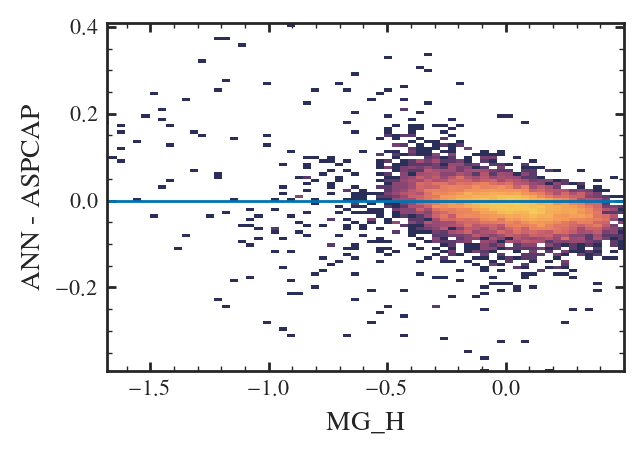

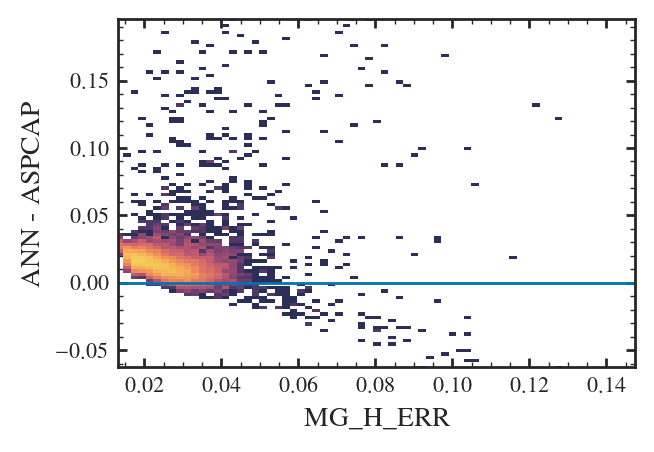

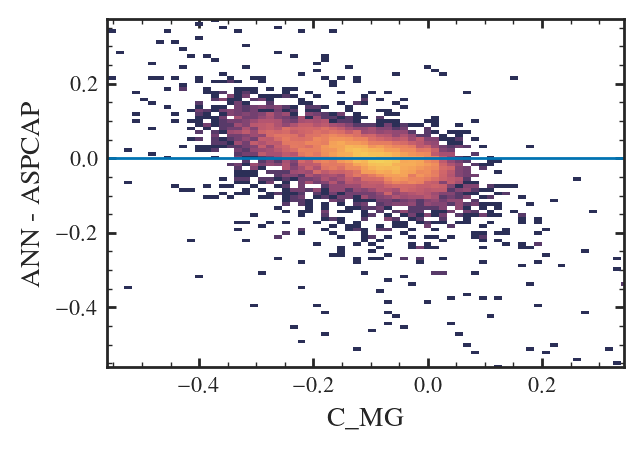

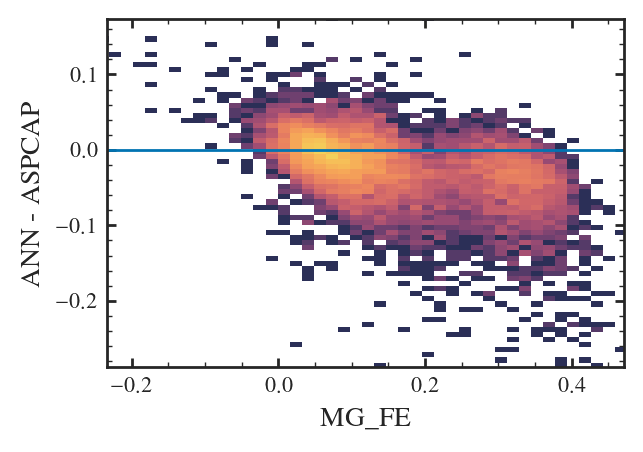

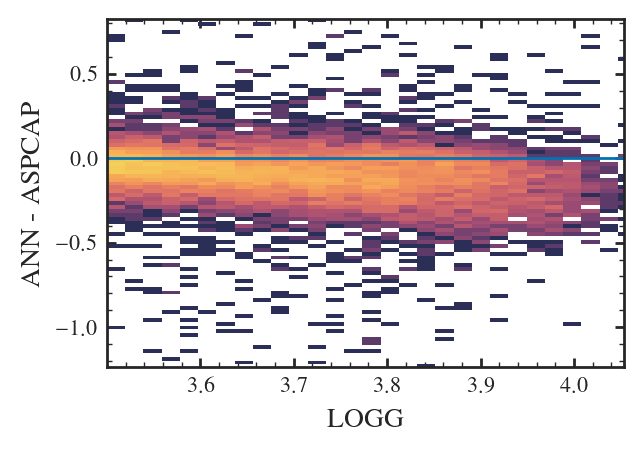

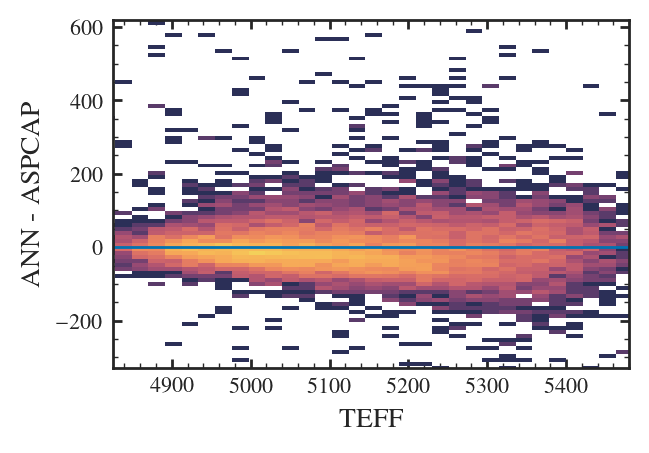

In [61]:
for ele in ["MG_H", "MG_H_ERR", "C_MG", "MG_FE", "LOGG", "TEFF"]:
    y = df[ele+"_ANN"] - df[ele]
    
    arya.hist2d(df[ele], y)
    plt.xlabel(ele)
    plt.ylabel("ANN - ASPCAP")
    plt.axhline(0)
    
    plt.xlim(np.percentile(df[ele], 0.1), np.percentile(df[ele], 99.9))
    plt.ylim(np.percentile(y[np.isfinite(y)], 0.1), np.percentile(y[np.isfinite(y)], 99.9))

    plt.show()

In [62]:
df["CI_C"] = df.CI_FE - df.C_FE

Text(0, 0.5, 'C abundance - C I abundance')

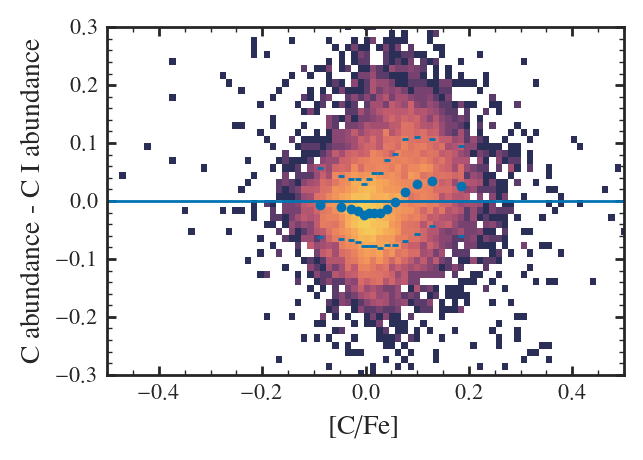

In [63]:
arya.hist2d(df.C_FE, df.CI_FE - df.C_FE);
arya.medianplot(df, "C_FE", "CI_C", binsize=1000, color=arya.COLORS[0])
plt.axhline(0)
plt.xlabel("[C/Fe]")
plt.xlim(-0.5, 0.5)
plt.ylim(-0.3, 0.3)
plt.ylabel("C abundance - C I abundance")

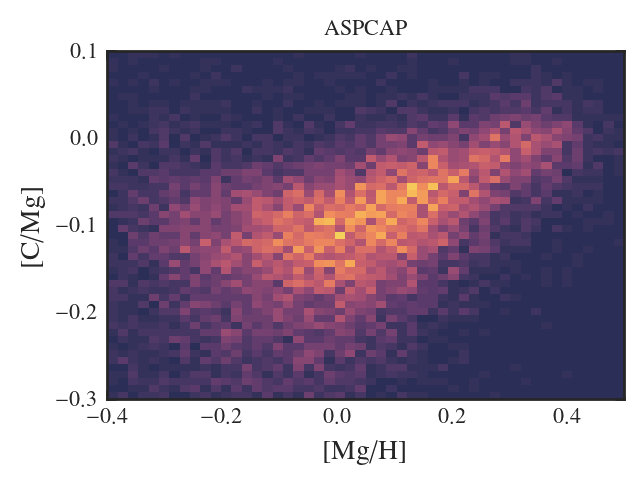

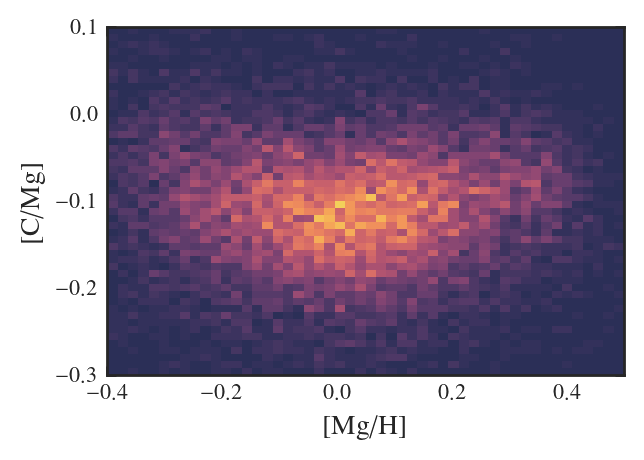

Text(0.5, 1.0, 'AstroNN')

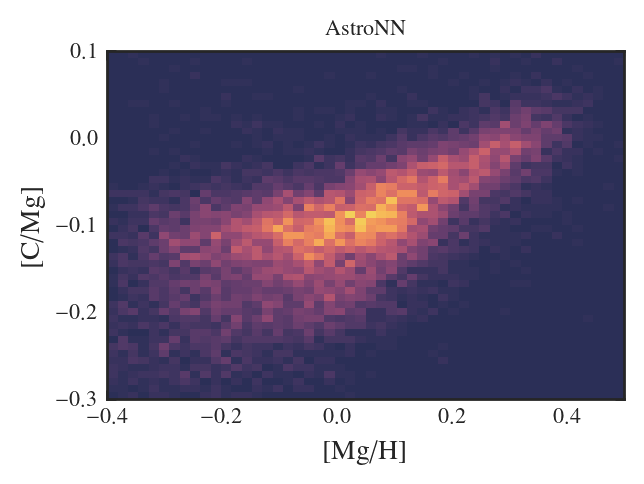

In [64]:
plt.hist2d(df.MG_H, df.C_MG, 50, range=([-0.4, 0.5], [-0.3, 0.1]));
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")
plt.title("ASPCAP")

plt.show()

plt.hist2d(df.MG_H, df.CI_FE - df.MG_FE, 50, range=([-0.4, 0.5], [-0.3, 0.1]));
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")
plt.show()
plt.title("ASPCAP, C i")


plt.hist2d(df.MG_H_ANN, df.C_MG_ANN, 50, range=([-0.4, 0.5], [-0.3, 0.1]));
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.title("AstroNN")


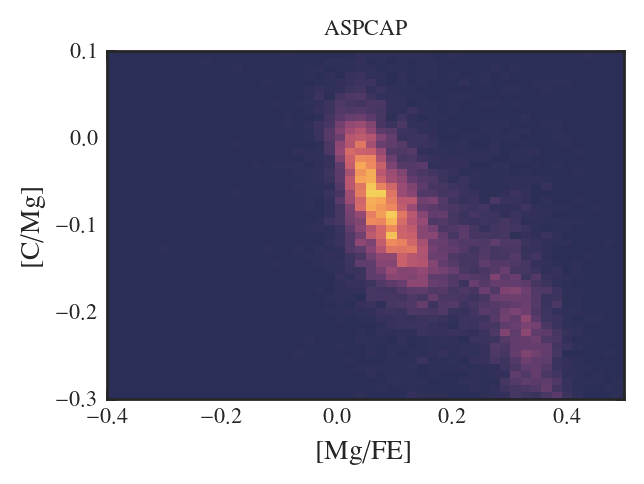

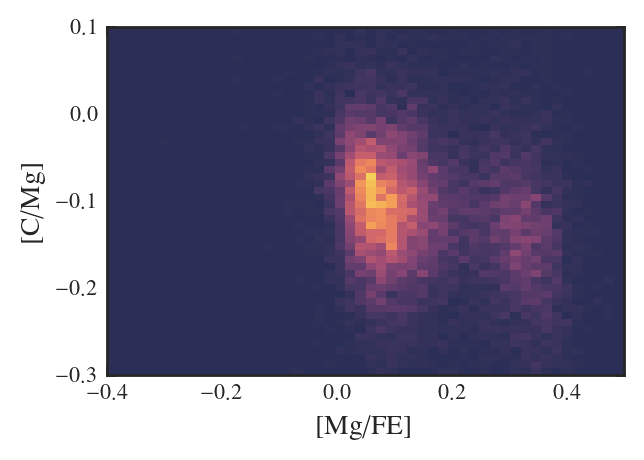

Text(0.5, 1.0, 'AstroNN')

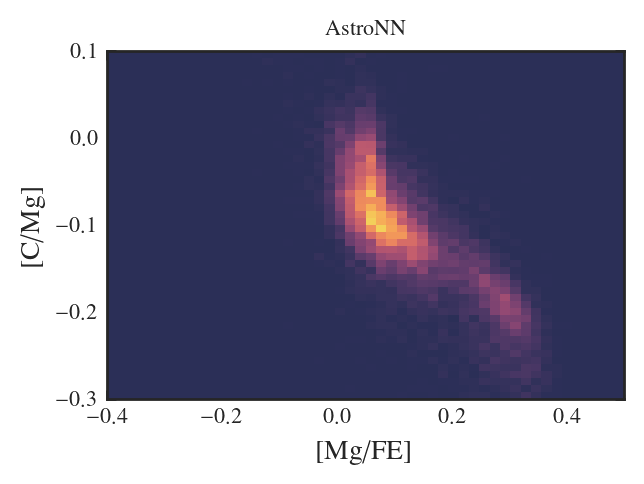

In [65]:
plt.hist2d(df.MG_FE, df.C_MG, 50, range=([-0.4, 0.5], [-0.3, 0.1]));
plt.xlabel("[Mg/FE]")
plt.ylabel("[C/Mg]")
plt.title("ASPCAP")

plt.show()

plt.hist2d(df.MG_FE, df.CI_FE - df.MG_FE, 50, range=([-0.4, 0.5], [-0.3, 0.1]));
plt.xlabel("[Mg/FE]")
plt.ylabel("[C/Mg]")
plt.show()
plt.title("ASPCAP, C i")


plt.hist2d(df.MG_FE_ANN, df.C_MG_ANN, 50, range=([-0.4, 0.5], [-0.3, 0.1]));
plt.xlabel("[Mg/FE]")
plt.ylabel("[C/Mg]")

plt.title("AstroNN")


## Reproducing jacks numbers

In [47]:
import numpy as np
from astropy.table import Table

filename =  DATA_DIR + "allStarLite-dr17-synspec.fits"

allStar = Table.read(filename, format="fits", hdu=1, memmap=True)


# apogee flags
apogee_target2 = 0
apogee_target2 ^= 1<<17 # APOGEE_MIRCLUSTER_STAR
apogee_target2 ^= 1<<15 # APOGEE_EMISSION_STAR  emission line stars
apogee_target2 ^= 1<<13 # APOGEE_EMBEDDEDCLUSTER_STAR embedded cluster

apogee2_target3 = 0
apogee2_target3 ^= 1<<1 # APOGEE2_EB eclipsing binary program
apogee2_target3 ^= 1<<5 # APOGEE2_YOUNG_CLUSTER # young cluster (IN-SYNC)
apogee2_target3 ^= 1<<18 # APOGEE2_W345 W3/4/5 star forming complex

extratarg = 1<<4 # DUPLICATE (keeps highest S/N observation)

mask = np.full(len(allStar), True)
mask &= (allStar["APOGEE2_TARGET3"] & apogee2_target3) == 0
mask &= (allStar["APOGEE_TARGET2"] & apogee_target2) == 0
mask &= (allStar["EXTRATARG"] & extratarg) == 0


# make sure no nans
for col in ["FE_H", "MG_FE", "C_FE", "LOGG", "TEFF", "N_FE"]:
    mask &= np.isfinite(allStar[col])
    mask &= np.isfinite(allStar[col + "_ERR"])

    
# logg - teff cut
    
logg = allStar["LOGG"]
teff = allStar["TEFF"]

mask &= logg >= 3.5
mask &= logg <= 0.004*teff - 15.7
mask &= logg <= 0.0007*teff + 0.36
mask &= logg <= -0.0015 * teff + 12.05
mask &= logg >= 0.0012*teff - 2.8


filtered = allStar[mask]
print("total", np.sum(mask))


# High alpha
fe_h = filtered["FE_H"]
filt_ha = (filtered["MG_FE"] >= 0.02 + 0.16 - 0.13 * (fe_h < 0) * fe_h) 
filt_ha &= fe_h >= -1.15
filt_ha &= fe_h <= 0.2

print("high alpha ", np.sum(filt_ha))


# low alpha

filt_la = (filtered["MG_FE"] <= -0.02 + 0.16 - 0.13 * (fe_h < 0) * fe_h) 
filt_la &= fe_h >= -0.75
filt_la &= fe_h <= 0.5

print("low alpha ", np.sum(filt_la))


total 13856
high alpha  3543
low alpha  9388


## Dwarfs

In [66]:
mask = np.full(len(allStarClean), True)

logg = allStarClean["LOGG"]
teff = allStarClean["TEFF"]
mask &= logg >= 4.2
mask &= teff >= 3000
mask &= teff <= 8000

np.sum(mask)

107691

In [67]:
dwarfs = allStarClean[mask].to_pandas()

In [68]:
dwarfs_pann = dwarfs.set_index("APOGEE_ID").join(astroNN).copy()


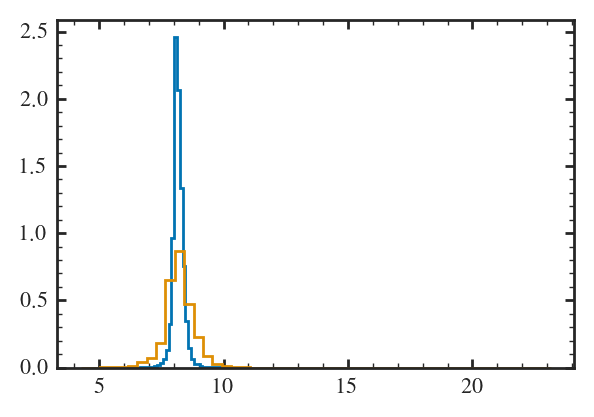

In [69]:
plt.hist(dwarfs_pann.galr_ANN,  density=True, histtype="step");
plt.hist(subgiants_pann.galr_ANN, density=True, histtype="step");

In [70]:
subgiants["CI_MG"] = subgiants["CI_FE"] - subgiants.MG_FE

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '[C/Mg]')

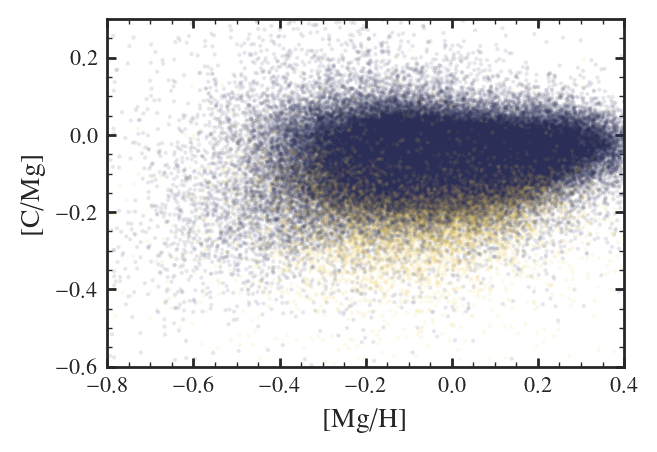

In [82]:
plt.scatter(dwarfs.MG_H, dwarfs.C_MG, s=0.3, alpha=0.1, c=dwarfs.high_alpha)
plt.xlim(-0.8, 0.4)
plt.ylim(-0.6, 0.3)


plt.legend()
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

In [74]:
subgiants["C_MG_ANN"] = subgiants.C_H_ANN - subgiants.MG_H_ANN

Text(0, 0.5, '[C/Mg]')

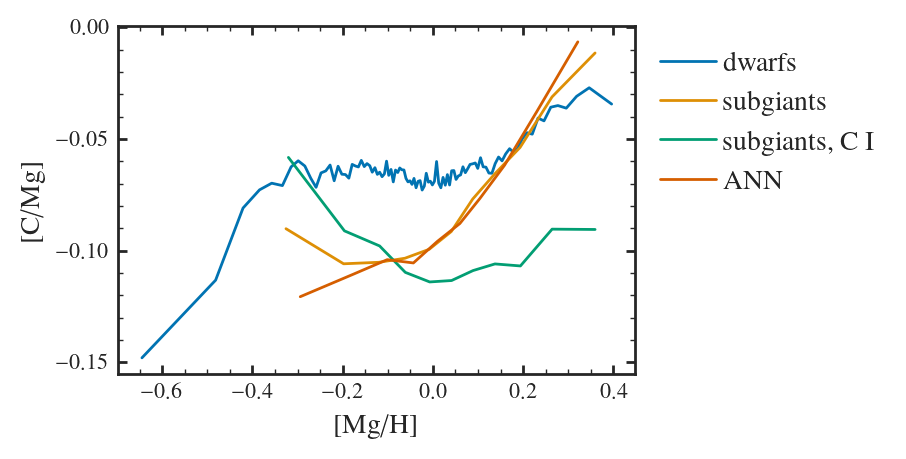

In [75]:
kwargs = dict(x="MG_H", y="C_MG", binsize=1_000, aes="line", errorbar=None)

arya.medianplot(dwarfs[~dwarfs.high_alpha], label="dwarfs", **kwargs)
arya.medianplot(subgiants[~subgiants.high_alpha], label="subgiants", color=arya.COLORS[1], **kwargs)
kwargs["y"] = "CI_MG"
arya.medianplot(subgiants[~subgiants.high_alpha], label="subgiants, C I", color=arya.COLORS[2], **kwargs)

kwargs["y"] = "C_MG_ANN"
kwargs["x"] = "MG_H_ANN"

arya.medianplot(subgiants[~subgiants.high_alpha], label="ANN", color=arya.COLORS[3], **kwargs)

arya.Legend(-1)
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

In [78]:
subgiants["MG_FE_ANN"] = subgiants["MG_H_ANN"] - subgiants["FE_H_ANN"]

Text(0, 0.5, '[C/Mg]')

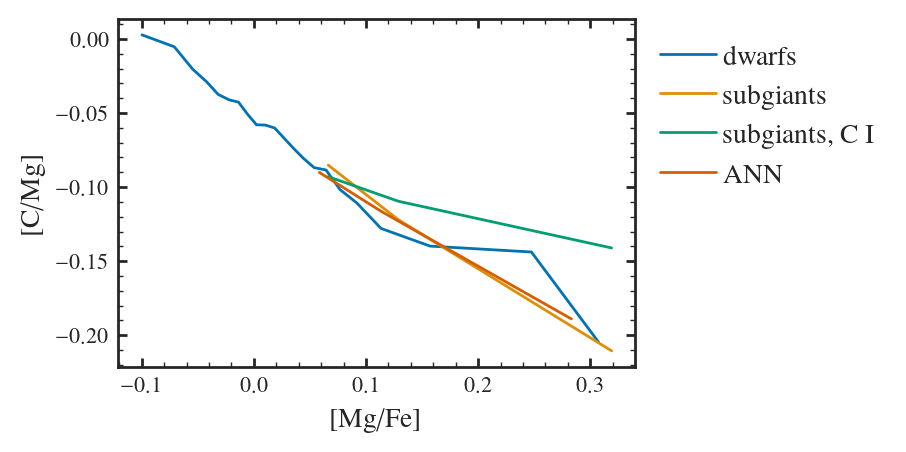

In [81]:
kwargs = dict(x="MG_FE", y="C_MG", binsize=1_000, aes="line", errorbar=None)


df = surp.plots.filter_metallicity(dwarfs)
arya.medianplot(df, label="dwarfs", **kwargs)

df = surp.plots.filter_metallicity(subgiants)

arya.medianplot(df, label="subgiants", color=arya.COLORS[1], **kwargs)

kwargs["y"] = "CI_MG"
arya.medianplot(df, label="subgiants, C I", color=arya.COLORS[2], **kwargs)

kwargs["y"] = "C_MG_ANN"
kwargs["x"] = "MG_FE_ANN"

arya.medianplot(df, label="ANN", color=arya.COLORS[3], **kwargs)

arya.Legend(-1)
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '[C/Mg]')

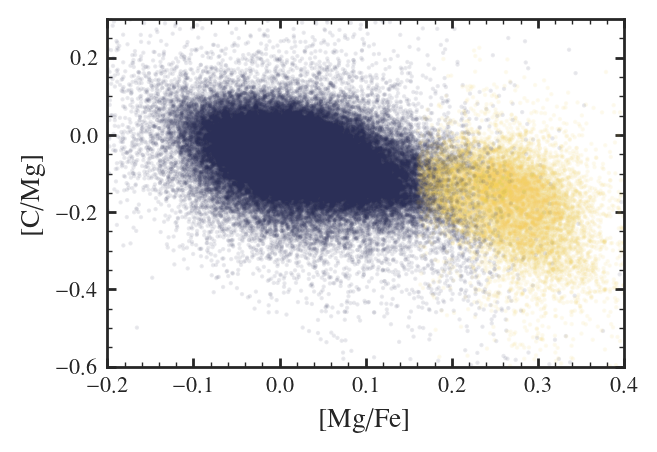

In [83]:
plt.scatter(dwarfs.MG_FE, dwarfs.C_MG, s=0.3, alpha=0.1, c=dwarfs.high_alpha)
plt.xlim(-0.2, 0.4)
plt.ylim(-0.6, 0.3)

plt.legend()
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

Text(0, 0.5, '$\\log$ g')

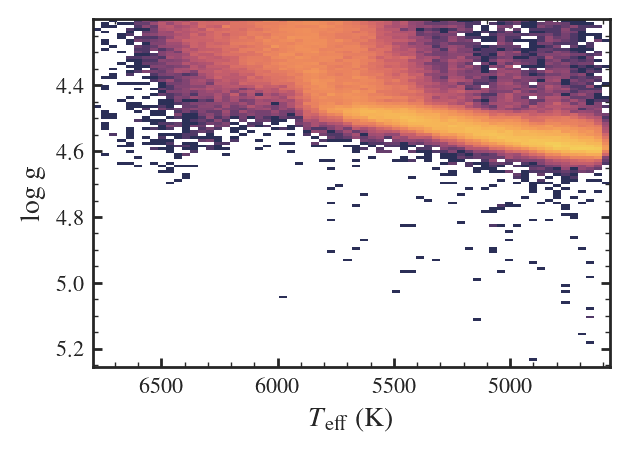

In [86]:
arya.hist2d(dwarfs.TEFF, dwarfs.LOGG)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel("$T_{\\rm eff}$ (K)")
plt.ylabel("$\\log$ g")

(-0.4, 0.5)

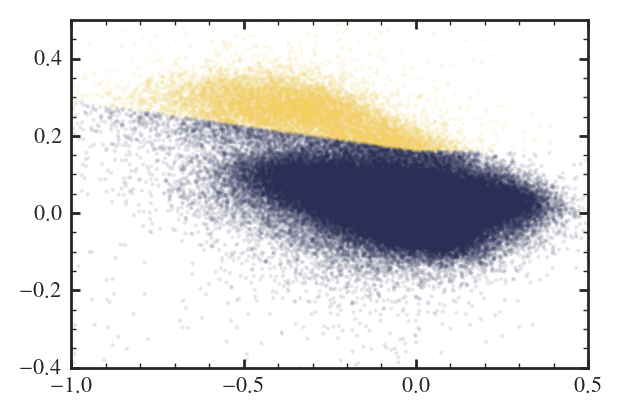

In [116]:
plt.scatter(dwarfs.FE_H, dwarfs.MG_FE, s=0.3, alpha=0.1, c=dwarfs.high_alpha)

plt.xlim(-1, 0.5)
plt.ylim(-0.4, 0.5)


(-0.4, 0.5)

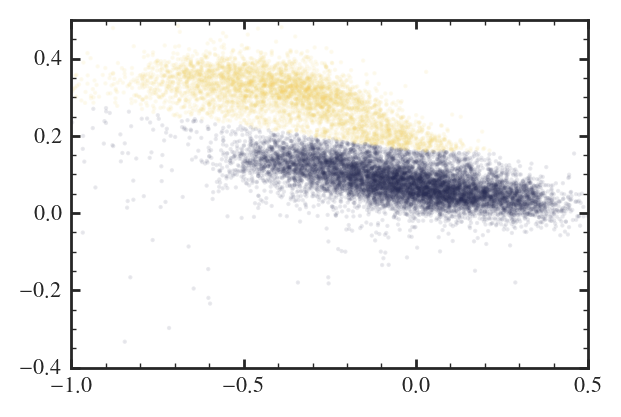

In [117]:
plt.scatter(subgiants.FE_H, subgiants.MG_FE, s=0.3, alpha=0.1, c=subgiants.high_alpha)

plt.xlim(-1, 0.5)
plt.ylim(-0.4, 0.5)


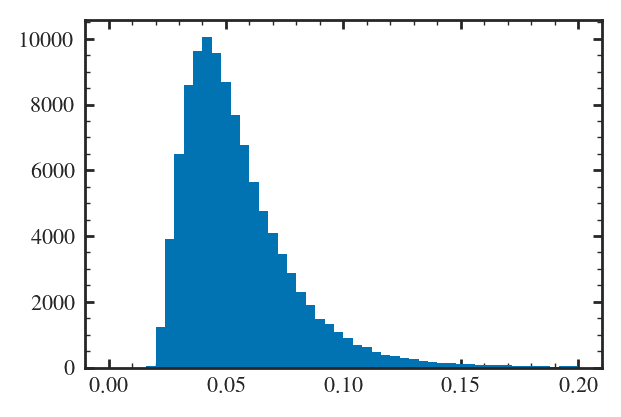

In [118]:
plt.hist(dwarfs.C_MG_ERR, range=(0, 0.2));

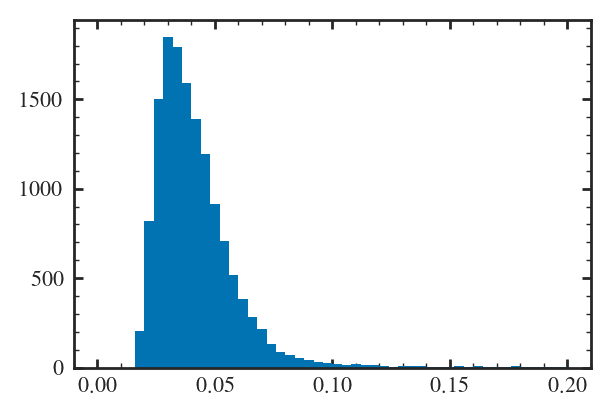

In [119]:
plt.hist(subgiants.C_MG_ERR, range=(0, 0.2));